# Mood-Based  Content Recommendation System for Chilio

## Problem Statement

Chilio's queer content is underperforming due to a content discovery and mood-matching issue. Users frequently select titles expecting one emotional tone (e.g., light and humorous) but encounter content with a dramatically different mood (e.g., intense and emotionally draining). This mismatch leads to poor viewing experiences, reduced engagement, and lower viewership for queer content on the platform.

## Business Objective

1. How can we match users with queer content that fits their current mood?

2. Can we reduce the number of incomplete or abandoned views by aligning recommendations with emotional expectations? 

3. How can we personalize queer content recommendations in a way that enhances emotional connection and user satisfaction?

4. How can we use mood as a recommendation input to complement traditional filters like genre or popularity?


## Project Flow
1. Understand the problem import libraries, load the data

2. Data Preprocessing 
    - Create a function that goes through the Movie Overview and a sign an emotion to. The emotions is housed in a seperate column
    - Feature Engineering 
    - Outlier Treatment 
    - Missing Value Treatment

3. Split the data 
    - Divide data into training(70%) and testing (30%)

4. Data Modeling 
    - Choose Model - Decision Trees
    - Train Model 
        - Feed training data into model
        - Adjust internal Parameters
    - Evaluate Model
        - F1 score to measure how well the model performs

5. Model Validation
    - Fine Tune Model
 


## 1. Import Libraries and Load Dataset

Because the project is about creating a mood based recommendation system NRCLEX is installed to help in creating a column to house the emotion of the each movie based on the Movie overview

In [1]:
#Import needed Libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
! pip install NRCLex
from nrclex import NRCLex


plt.style.use('seaborn-v0_8-darkgrid')

In [2]:
#Load dataset

data = pd.read_csv('lgbtq_movies.csv')

data.head()


,id,title,original_title,original_language,overview,release_date,popularity,vote_average,vote_count,adult,video,genre_ids
0,860159,Crush,Crush,en,When an aspiring young artist is forced to joi...,2022-04-29,321.755,7.5,120,False,False,"[35, 10749]"
1,719088,"Yes, No, or Maybe Half?",イエスかノーか半分か,ja,"Kunieda Kei is a popular, young TV announcer w...",2020-12-11,139.229,7.1,26,False,False,"[16, 18, 10749]"
2,632632,Given,映画 ギヴン,ja,The film centers on the love relationship amon...,2020-08-22,110.140,8.4,318,False,False,"[16, 18, 10402, 10749]"
3,929477,Heart Shot,Heart Shot,en,Teenagers Nikki and Sam are in love and planni...,2022-02-17,88.760,5.4,37,False,False,"[10749, 80]"
4,197158,Porno,Pornô!,pt,Three tales of the erotic: Two young ladies ex...,1981-01-01,76.302,4.3,46,False,False,[18]


## 2. Data Preprocessing

This step is important in the project as it will in removing data that would hinder our outcome such as missing overviews or null values, it is also needed to deal with categorical data and detect outliers


In [3]:
#Check for missing values
data.isnull().sum()

id                    0
title                 0
original_title        0
original_language     0
overview             77
release_date         90
popularity            0
vote_average          0
vote_count            0
adult                 0
video                 0
genre_ids             0
dtype: int64

In [4]:
#Understand the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7165 entries, 0 to 7164
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 7165 non-null   int64  
 1   title              7165 non-null   object 
 2   original_title     7165 non-null   object 
 3   original_language  7165 non-null   object 
 4   overview           7088 non-null   object 
 5   release_date       7075 non-null   object 
 6   popularity         7165 non-null   float64
 7   vote_average       7165 non-null   float64
 8   vote_count         7165 non-null   int64  
 9   adult              7165 non-null   bool   
 10  video              7165 non-null   bool   
 11  genre_ids          7165 non-null   object 
dtypes: bool(2), float64(2), int64(2), object(6)
memory usage: 573.9+ KB


In [5]:
#Change release_date to release_year 

data['release_year'] = pd.to_datetime(data['release_date']).dt.year.fillna(0).astype(int)
data['release_year'].tail()

7160    2010
7161       0
7162    2001
7163    2022
7164    2022
Name: release_year, dtype: int32

In [6]:
#Drop release_date column as it is not longer needed
data.drop(columns=['release_date'], inplace=True)

In [7]:
#Drop unnecessary columns
data.drop(columns=['vote_count', 'adult', 'video'],inplace=True)

In [8]:
#Load genres data
genre = pd.read_csv('movies_genres.csv')
genre

,genre_ids,name
0,28,Action
1,12,Adventure
2,16,Animation
3,35,Comedy
4,80,Crime
5,99,Documentary
6,18,Drama
7,10751,Family
8,14,Fantasy
9,36,History


In [9]:
# Convert genre_ids from string representation of list to actual list if needed
if isinstance(data['genre_ids'].iloc[0], str):
	import ast
	data['genre_ids'] = data['genre_ids'].apply(ast.literal_eval)

# Explode genre_ids so each row has a single genre id
data_exploded = data.explode('genre_ids')

# Drop rows where genre_ids is NaN before converting to int
data_exploded = data_exploded.dropna(subset=['genre_ids'])
data_exploded['genre_ids'] = data_exploded['genre_ids'].astype(int)

# Merge with genre DataFrame
content = pd.merge(data_exploded, genre, on='genre_ids', how='left')
content

,id,title,original_title,original_language,overview,popularity,vote_average,genre_ids,release_year,name
0,860159,Crush,Crush,en,When an aspiring young artist is forced to joi...,321.755,7.5,35,2022,Comedy
1,860159,Crush,Crush,en,When an aspiring young artist is forced to joi...,321.755,7.5,10749,2022,Romance
2,719088,"Yes, No, or Maybe Half?",イエスかノーか半分か,ja,"Kunieda Kei is a popular, young TV announcer w...",139.229,7.1,16,2020,Animation
3,719088,"Yes, No, or Maybe Half?",イエスかノーか半分か,ja,"Kunieda Kei is a popular, young TV announcer w...",139.229,7.1,18,2020,Drama
4,719088,"Yes, No, or Maybe Half?",イエスかノーか半分か,ja,"Kunieda Kei is a popular, young TV announcer w...",139.229,7.1,10749,2020,Romance
...,...,...,...,...,...,...,...,...,...,...
8301,37889,Flex Appeal,Flex Appeal,en,Ron Williams' latest foray into the beauty of ...,0.600,0.0,99,2003,Documentary
8302,983153,God,dEUs,pt,Gustavo is a young adult attending law school....,0.000,0.0,18,0,Drama
8303,983027,To My Star 2: Our Untold Stories,나의 별에게2 : 우리의 못다 한 이야기,ko,After his career took a steady turn for the wo...,0.000,0.0,18,2022,Drama
8304,983027,To My Star 2: Our Untold Stories,나의 별에게2 : 우리의 못다 한 이야기,ko,After his career took a steady turn for the wo...,0.000,0.0,10749,2022,Romance


In [10]:
#Rename genre column to genre_name
content.rename(columns={'name': 'genre_name'}, inplace=True)
content.head()

,id,title,original_title,original_language,overview,popularity,vote_average,genre_ids,release_year,genre_name
0,860159,Crush,Crush,en,When an aspiring young artist is forced to joi...,321.755,7.5,35,2022,Comedy
1,860159,Crush,Crush,en,When an aspiring young artist is forced to joi...,321.755,7.5,10749,2022,Romance
2,719088,"Yes, No, or Maybe Half?",イエスかノーか半分か,ja,"Kunieda Kei is a popular, young TV announcer w...",139.229,7.1,16,2020,Animation
3,719088,"Yes, No, or Maybe Half?",イエスかノーか半分か,ja,"Kunieda Kei is a popular, young TV announcer w...",139.229,7.1,18,2020,Drama
4,719088,"Yes, No, or Maybe Half?",イエスかノーか半分か,ja,"Kunieda Kei is a popular, young TV announcer w...",139.229,7.1,10749,2020,Romance


In [11]:
#Installed TextBlob for sentiment analysis after error with nltk
%pip install --upgrade textblob

from textblob import download_corpora
download_corpora.download_all()

Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\002401\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\002401\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\002401\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\002401\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\002401\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\002401\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews 

In [12]:
#Create a function to get emotions from text using NRCLex and filter out emotion scores of 0
def get_emotions(text):
    if pd.isna(text):
        return 'None'
    emotions = NRCLex(str(text))
    emotions_scores = emotions.affect_frequencies
    if isinstance(emotions_scores, dict):
        filtered_emotions = {emotion: score for emotion, score in emotions_scores.items() if score > 0}
        if filtered_emotions:
            return max(filtered_emotions, key=filtered_emotions.get)
        else:
            return 'None'
    else:
        return 'None'

content['emotions'] = content['overview'].apply(get_emotions)
content['emotions'].head()

0    positive
1    positive
2       trust
3       trust
4       trust
Name: emotions, dtype: object

In [13]:
#Combine duplicates by genre_name and id 
content = content.groupby('id').agg({
    'title' : 'first',
    'original_title' : 'first',
    'original_language' : 'first',
    'overview' : 'first',
    'popularity' : 'first',
    'release_year' : 'first',
    'vote_average' : 'first',
    'popularity' : 'first',
    'emotions' : lambda x: ','.join(x.unique()),
    'genre_name' : lambda x: ','.join(x.unique()),
    'genre_ids' : lambda x: ','.join(map(str, x.unique()))   
})
content.reset_index(inplace=True)
content.head(20)

,id,title,original_title,original_language,overview,popularity,release_year,vote_average,emotions,genre_name,genre_ids
0,14,American Beauty,American Beauty,en,"Lester Burnham, a depressed suburban father in...",32.508,1999,8.0,trust,Drama,18
1,26,Walk on Water,LaLehet Al HaMayim,he,"Eyal, an Israeli Mossad agent, is given the mi...",4.800,2004,6.9,positive,Drama,18
2,71,Billy Elliot,Billy Elliot,en,Set against the background of the 1984 Miners'...,19.989,2000,7.6,anger,"Drama,Comedy,Music","18,35,10402"
3,142,Brokeback Mountain,Brokeback Mountain,en,Two modern-day cowboys meet on a shepherding j...,31.967,2005,7.8,positive,"Drama,Romance","18,10749"
4,226,Boys Don't Cry,Boys Don't Cry,en,A young transgender man explores his gender id...,12.260,1999,7.5,positive,"Crime,Drama","80,18"
5,294,Desert Hearts,Desert Hearts,en,The story of straight-edge literature professo...,8.737,1985,7.1,positive,"Drama,Romance","18,10749"
6,321,Mambo Italiano,Mambo Italiano,en,"When an Italian man comes out of the closet, i...",4.966,2003,5.8,fear,"Comedy,Romance","35,10749"
7,340,Everything Is Illuminated,Everything Is Illuminated,en,A young Jewish American man endeavors—with the...,8.381,2005,7.3,positive,"Comedy,Drama","35,18"
8,342,Summer Storm,Sommersturm,de,"Tobi and Achim, the pride of the local crew cl...",9.686,2004,6.8,trust,"Comedy,Drama","35,18"
9,349,Cockles and Muscles,Crustacés et coquillages,fr,Crustacés et coquillages is a fresh French com...,3.138,2005,6.2,positive,Comedy,35


In [14]:
#Emotion mapping
emotion_mapping = {
    'positive' : 'happy',
    'trust' : 'hopeful',
    'negative': 'bleak',
    'fear' : 'scary',
    'None' : 'neutral',
    'anticipation' : 'intriguing',
    'surprise' : 'shocking',
    'anger' : 'intense',
    'sadness' : 'melancholic',
    'joy' : 'lighthearted',
    'disgust' : 'unsettling'
    
    }

content['emotions'] = content['emotions'].map(emotion_mapping)

In [15]:
#Peruse the emotions column to count occurrences of each emotion
content['emotions'].value_counts()

emotions
happy           2498
hopeful          836
bleak            747
scary            577
neutral          256
intriguing       185
shocking         144
intense          113
melancholic       22
lighthearted      14
unsettling         5
Name: count, dtype: int64

In [17]:
#Feature engineering 
from sklearn.preprocessing import OneHotEncoder

#Create a copy of the content DataFrame to avoid modifying the original and drop unnecessary columns
content_encoded = content.copy()

content_encoded = content_encoded.drop(columns=['id', 'original_language', 'title', 'vote_average', 'popularity', 'release_year', 'genre_ids'])

content_encoded


,original_title,overview,emotions,genre_name
0,American Beauty,"Lester Burnham, a depressed suburban father in...",hopeful,Drama
1,LaLehet Al HaMayim,"Eyal, an Israeli Mossad agent, is given the mi...",happy,Drama
2,Billy Elliot,Set against the background of the 1984 Miners'...,intense,"Drama,Comedy,Music"
3,Brokeback Mountain,Two modern-day cowboys meet on a shepherding j...,happy,"Drama,Romance"
4,Boys Don't Cry,A young transgender man explores his gender id...,happy,"Crime,Drama"
...,...,...,...,...
5392,Celestial Transits,A young woman named Olive struggles to define ...,intriguing,"Animation,Fantasy,Drama"
5393,Ça n'est pas le temps des romans,None,neutral,Drama
5394,A boy and his friend,"At a house party, Aaron comes of age when sear...",hopeful,Drama
5395,나의 별에게2 : 우리의 못다 한 이야기,After his career took a steady turn for the wo...,scary,"Drama,Romance"


In [18]:
#Divide the feature data into categorical and numerical features
cat_features = [['genre_name', 'original_title' 'overview']]



In [19]:
# Fix cat_features to be a flat list of column names
cat_features = ['genre_name', 'original_title', 'overview']

# Create One hot encoding for categorical features
ohe = OneHotEncoder(handle_unknown='ignore')

# Fit and transform the categorical feature columns
cat_features_ohe = ohe.fit_transform(content_encoded[cat_features])



In [20]:

# Convert the sparse matrix to a DataFrame
cat_features_df = pd.DataFrame(cat_features_ohe.toarray(), columns=ohe.get_feature_names_out(cat_features))
# Concatenate the original DataFrame with the new one-hot encoded DataFrame
content_encoded = pd.concat([content_encoded, cat_features_df], axis=1)
# Drop the original categorical columns 
content_encoded = content_encoded.drop(columns=cat_features)

## 3. Split The Data

Splitting the data into 2: 

        1. Training data - This is the data that I will be used to train the model. For this we will use 70% of the dataset
        2. Test data - This is the data that I will use to check if the accuracy of the model. 30% of the dataset will be used


In [21]:
# Split the data into features and target variable
# Use all one-hot encoded columns plus 'release_year' and 'popularity'
X = content_encoded.drop(columns=['emotions'])
y = content_encoded['emotions']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## 4. Data Modeling
Visualizing our data to see how they communicate by feeding the training data into the model.

For this project I will be using Decision Trees because it offers potential options & choices are considered at the same time.

In [22]:
#Create Classifier

clf= DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)
clf.fit(X_train,y_train)



DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)

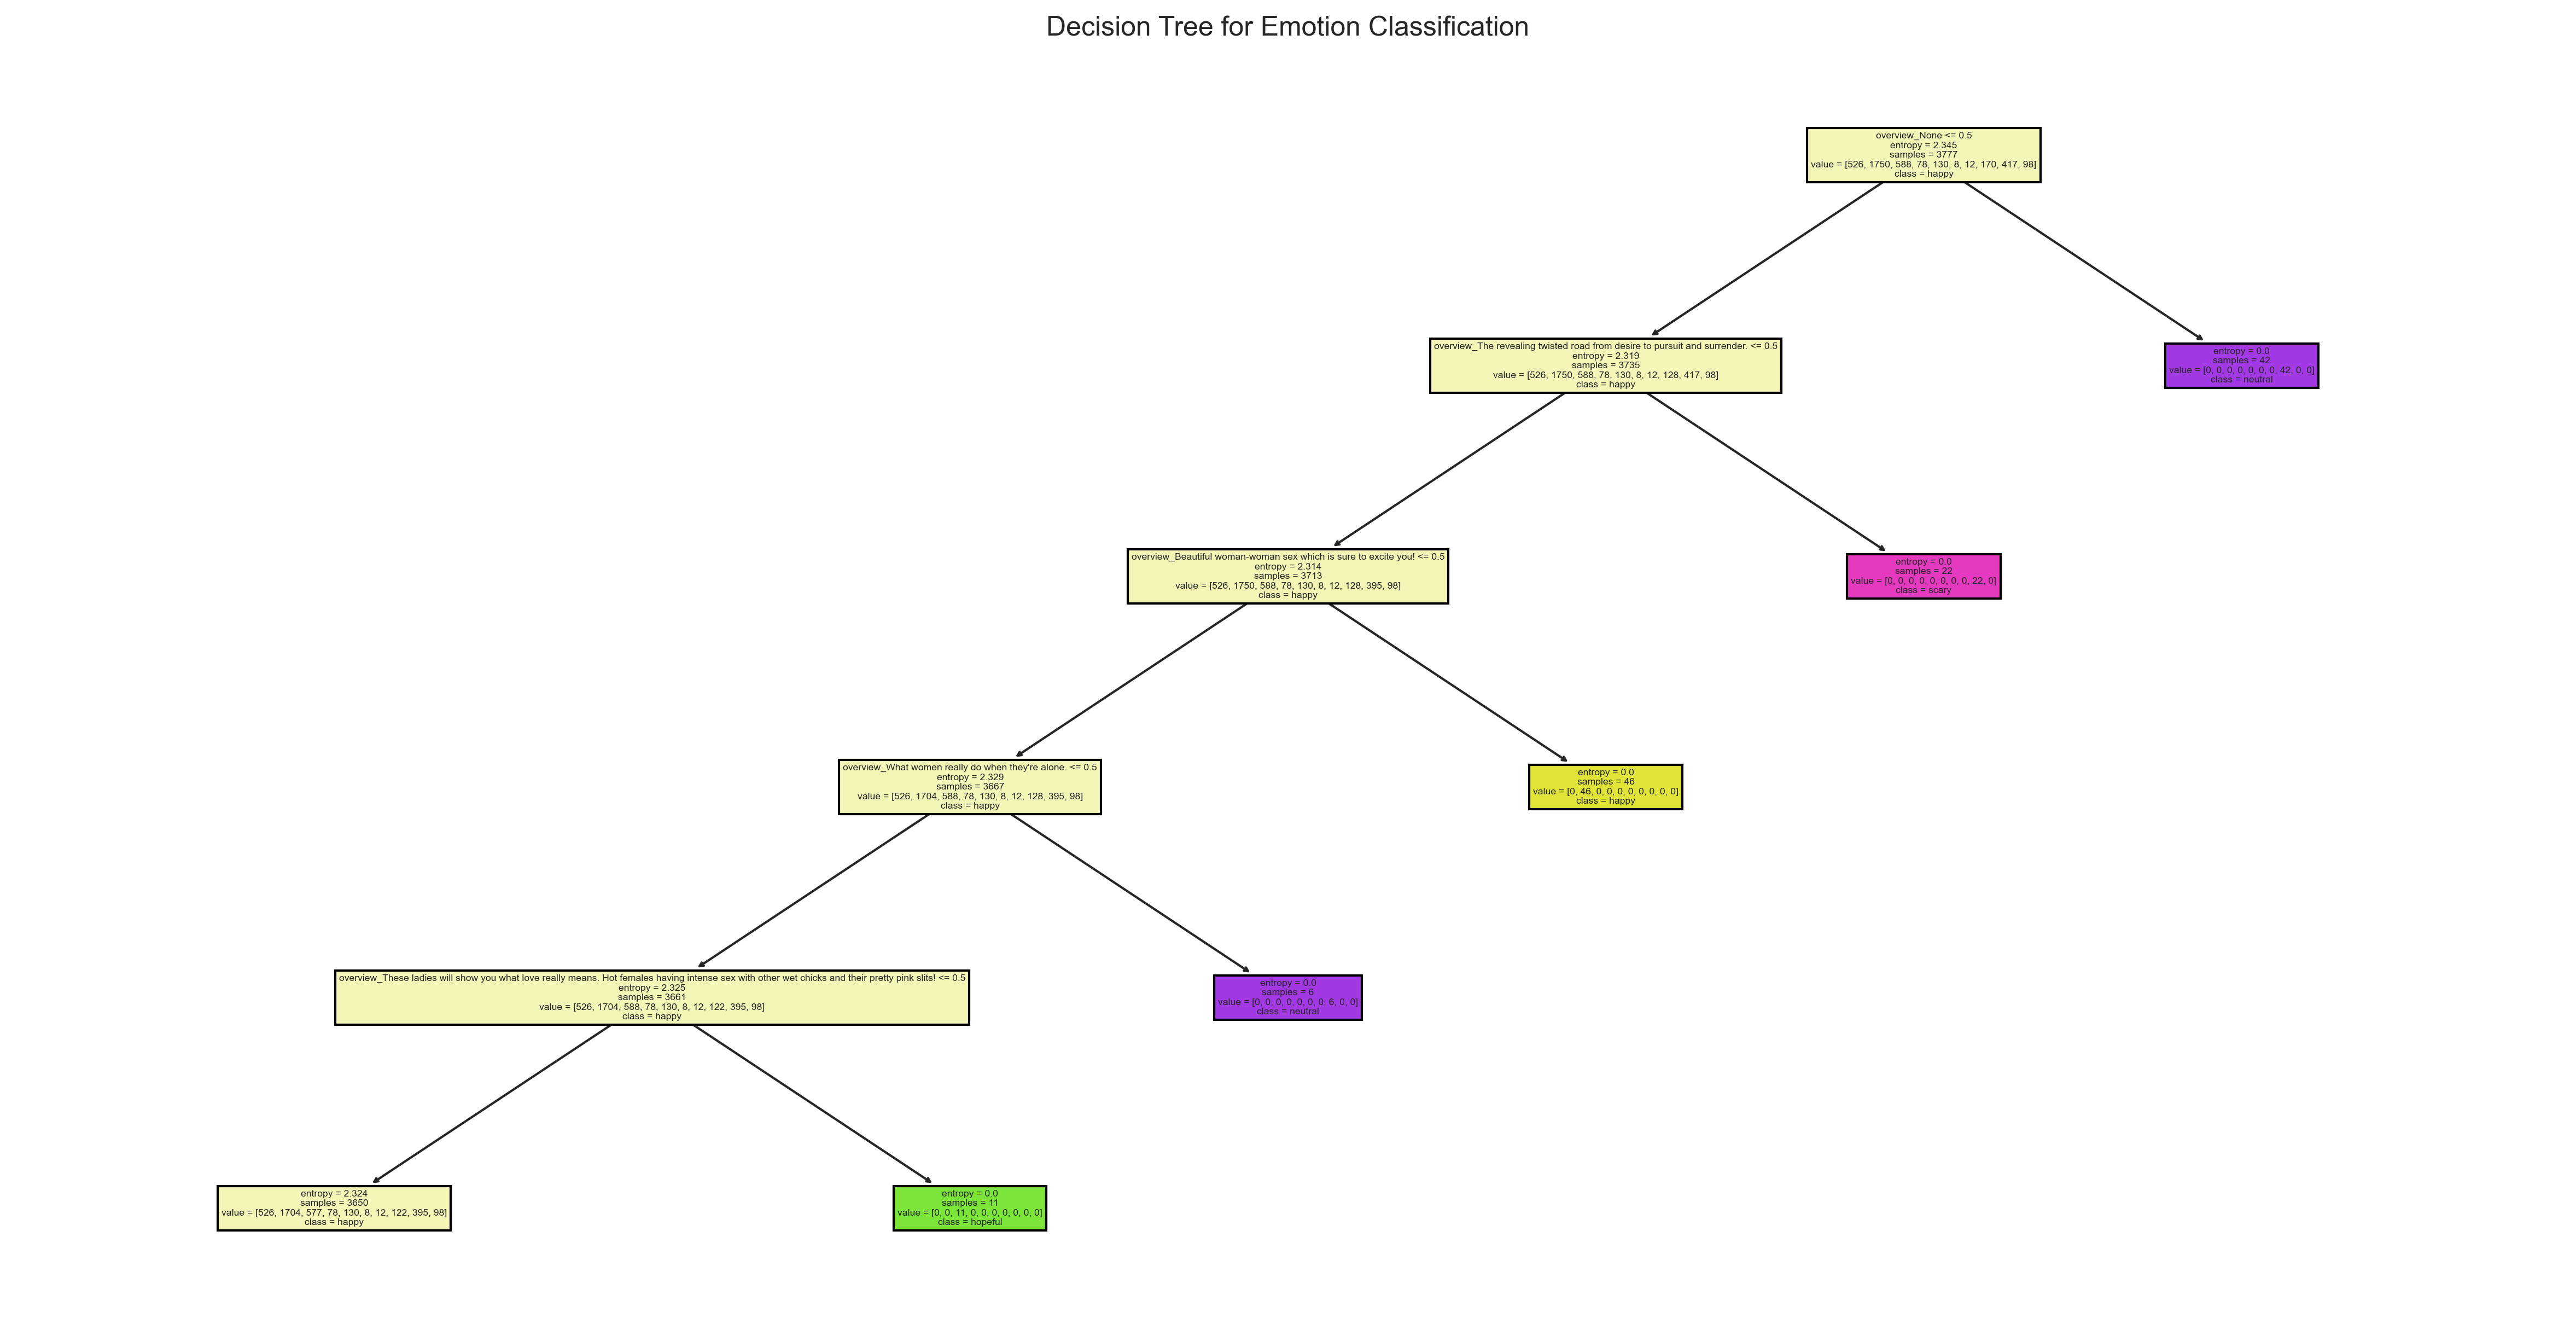

In [23]:
#Plot decision tree
from sklearn.tree import plot_tree

fig,axes = plt.subplots(nrows=1, ncols=1, figsize= (20,10), dpi= 300)
plot_tree(clf,
          feature_names=X.columns,
          class_names=clf.classes_,
          filled=True)

plt.title('Decision Tree for Emotion Classification')
plt.show()

In [24]:
# Evaluate the model
from sklearn.metrics import accuracy_score as accuracy_scores

# Predict using the test set
y_pred = clf.predict(X_test)

print('Accuracy: ', accuracy_scores(y_test, y_pred))

Accuracy:  0.48518518518518516


An accuracy of 48% indicates that the model has performed poorly, i.e a weak model 

In [25]:
#Calculatre y probabilities and roc and auc curve
y_prob = clf.predict_proba(X_test)
fpr,tpr, thresholds = roc_curve(y_test,y_prob[:,1], pos_label='happy')

roc_curve = auc(fpr, tpr)
roc_curve


0.5288215056664868

In [26]:
#F1 score
from sklearn.metrics import f1_score
f1 = f1_score(y_test,y_pred, average='weighted')
f1_macro = f1_score(y_test,y_pred,average='macro')
f1_micro = f1_score(y_test,y_pred,average='micro')

print(f'F1 Score(weighted): {f1}')
print(f'F1 Score(Macro): {f1_macro}')
print(f'F1 Score(Micro): {f1_micro}')

F1 Score(weighted): 0.33653112539563373
F1 Score(Macro): 0.1110228349985361
F1 Score(Micro): 0.48518518518518516


Reintroduce the numerical features - Normalize or scale popularity if it has wide variance.
Maybe some logistic regression and analyse the coefficients to figure out best features

In [ ]:
from imblearn.over_sampling import SMOTE
#Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train,y_train)

y_train_balanced.value_counts()

In [ ]:
#Train classifier on balanced data
clf= DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)
clf.fit(X_train_balanced,y_train_balanced)

In [ ]:
# Predict using the test set
y_pred_balanced = clf.predict(X_test)
print('Accuracy: ', accuracy_scores(y_test, y_pred_balanced))

In [ ]:
f1_bal = f1_score(y_test,y_pred_balanced, average='weighted')
f1_macro_bal = f1_score(y_test,y_pred_balanced,average='macro')
f1_micro_bal = f1_score(y_test,y_pred_balanced,average='micro')

print(f'F1 Score(weighted): {f1_bal}')
print(f'F1 Score(Macro): {f1_macro_bal}')
print(f'F1 Score(Micro): {f1_micro_bal}')